<h1><center>D213: Advanced Data Analytics</center></h1>
<br>
<center>Task 1: Time Series Modeling</center>
<br>
<center></center>
<br>
<center>Department of Information Technology, Western Governor's University</center>
<br>
<center>Dr. William Sewell</center>
<br>
<center>September 16, 2024</center>
<br>
<br>
<br>
<br>

## A1. Research Question
Because this paper is about time series analysis, my research question will be simple and focus on what time series analysis is designed for: forecasting. Thus, my research question is, "Can we use historical data to accurately forecast WGU Hospital's daily revenues for a roughly five-month period?"

## A2. Analysis Goals
The goal of this time series analysis is to accurately forecast WGU Hospital's daily revenues roughly five months out into the future using historical data. The time period I've chosen is partially due to the fact that I will later split the dataset such that 80% is used for training, and the other 20% is used for testing purposes. This resulted in just under five months of data in the test set. I will use an ARIMA model to forecast the values of the test set, then compare the forecast to the actual test set values. Then, I will evaluate how effective the time series model was at forecasting the roughly five-month period.

## B. Time Series Modeling Assumptions
* Data does not contain anomalies/outliers
* The data series is stationary, which means that the mean and variance should not vary with time. A series can be made stationary by using log transformation or differencing the series.
* The data provided as input must be a univariate series, since arima uses the past values to predict the future values.
* Past datapoints are indicative of the behavior of future datapoints

The ARIMA model works on a few assumptions, listed below.

* The time series data must be stationary or be able to be made stationary
* The time series data must not contain outliers or anomalies
* The time series data must be univariate
* Past data points in the time series data must be indicative of the behavior of future datapoints.

Stationarity is a key assumption for the ARIMA model, meaning the data's mean and variance should not change depending on time (Singh, 2023). If the data is not stationary, we can attempt to make it stationary by differencing the data, which is done by taking the difference between the time series datapoints. To clarify, suppose we have a time series with datapoints $x_{t}$ = 2, $x_{t+1}$ = 7, and $x_{t+2}$ = 5. If we difference this time series, we would get $d_{t}$ = NaN, $d_{t+1}$ = 5, and $d_{t+2}$ = -2. Typically, the NaN at the start of the series is dropped. ARIMA is able to deal with differencing non-stationary data, meaning we can feed ARIMA non-stationary data so long as we provide it a $d$ term. If only one differencing is needed to make non-stationary time series data stationary, then $d = 1$. The "I" in ARIMA stands for "integrated", and this is what handles differencing the data if needed.

A second assumption that requires some explanation is the fourth one in the bulleted list-- that past datapoints should be indicative of the behavior of future datapoints. ARIMA contains the component AR, which stands for "autoregressive." Autoregressive models predict future datapoints based on past datapoints and rely on the data being autocorrelated. An autocorrelated dataset is a dataset that is correlated (has a relationship) with a lagged version of itself. The higher this correlation is, the more accurate the model is at predicting future datapoints (*What Are Autoregressive Models? - AR Models Explained - AWS*, n.d.). The amount of lag can be specified-- this is the $p$ term in an ARIMA model. For example, a lag-one model will use the immediately preceding datapoint to predict the next, whereas a lag-two model predicts based on the previous two values-- and so on.

The two assumptions that the data must be univariate and free of outliers or anomalies are fairly self-explanatory. In order to be univariate, the time series must contain only one variable. In the dataset below, this variable is revenue. ARIMA, unlike multiple linear regression, cannot create a linear combination of the effects of many variables on a response variable. It is designed to use past datapoints to predict future datapoints. Obviously, having outliers or large anomalies will negatively impact a model that uses the past to predict the future, as such breaks in the patterns of the past will negatively impact the model's predictive power.

## C1. Visualizing the Time Series Data

Below, I will load the data and create a line graph of the time series data. It is important to note, however, that when I loaded the data into a dataframe, I noticed the data contained only a "Day" value, which is only an integer value that increments each day that passes in the data. While time series analysis *can* be done on data such as this, it is not preferable. In the real world, one would expect to see a datetime column of dates.

I checked the data dictionary that accompanies this dataset to ascertain the real timeframe during which this data was collected, but I found none. Thus, I have decided to give it a "Date" column with datetimes in a range that are something I would expect to see in my own work at my employer. This range represents the fiscal year my employer uses and spans 10-1-2019 through 9-30-2021, which equates to two fiscal years (fiscal years 2020 and 2021.) I believe doing this provides some good context in which to analyze the time series data, and later, the predictions of the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import data and check it visually
df = pd.read_csv('C:/Users/essay/Documents/D213 PA Dataset/medical_time_series.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [3]:
df

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


In [4]:
# Pick a start date, since data dictionary doesn't tell us what that is.
# I'm going to pretend like the start date is something we would reasonably use
# for my current employer. Our fiscal year starts on October 1st.

start_date = pd.to_datetime('2019-10-01')
# Convert the day counter column to something more useful-- datetime.
df['Date'] = pd.to_timedelta(df['Day']-1, unit='D') + start_date
# Make Date column the new index. Drop old column.
df.set_index('Date', inplace=True)
df.drop('Day', axis=1, inplace=True)
df

,Revenue
Date,
2019-10-01,0.000000
2019-10-02,-0.292356
2019-10-03,-0.327772
2019-10-04,-0.339987
2019-10-05,-0.124888
...,...
2021-09-26,15.722056
2021-09-27,15.865822
2021-09-28,15.708988


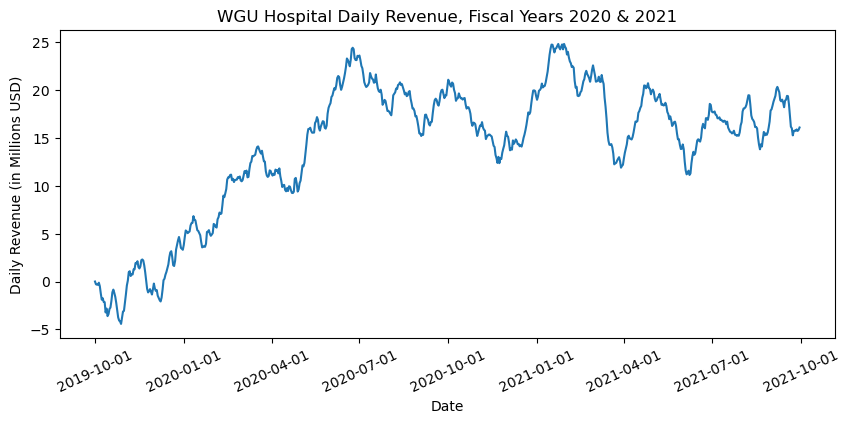

In [5]:
# Create visualization of time series data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x='Date', y='Revenue', data=df, ax=ax)
ax.tick_params(axis='x', rotation = 25)
ax.set_ylabel('Daily Revenue (in Millions USD)')
ax.set_title('WGU Hospital Daily Revenue, Fiscal Years 2020 & 2021')

# Date format annoys me, so I'll fix it here
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

plt.show()

In the above line plot, one can see that the time series data clearly has an upward trend in revenue from 10-1-2019 through 7-1-2020. Thereafter, it flattens out a bit, though a very small downward trend and then a very small upward trend can be seen in the periods 7-1-2020 through 1-1-2021 and 7-1-2021 through 9-30-2021 respectively.

From this graph alone, it is difficult to spot any seasonality in the data. More in-depth analysis is required to ascertain whether or not a seasonality component is present.

## C2. Time Step Formatting
The original time series is 731 datapoints long, with each datapoint corresponding to each day's revenue in millions of dollars USD. In the original dataset, these days are designated by an integer that increments by one on each row from 1 to 731-- a simple count of the number of days elapsed from the start of data collection.

Because I wanted a context in which to analyze this data, I replaced this "Day" column at my own discretion with a column of datetime values. The data dictionary did not state the exact time period in which this data was collected, so I used one that would be commonly used at my work-- two fiscal years (2020 and 2021.) However, the time steps remain the same. The new "Date" column increments the same way the "Day" column did-- each row represents the day's revenue in millions of dollars, except now there's more context for when these measurements "took place." In addition to providing context, having a "Date" column that contains datetime values makes it easier to aggregate the data by week, month, year, etc. 

The data begins on 10-1-2019 and each row increments one day until the data ends on 9-30-2021, which corresponds exactly to the length of two fiscal years. There appear to be no gaps in measurement-- all days are accounted for, including the leap year day in 2020 (2-29-2020.)

## C3. Stationarity
Below, you'll see the code used to perform an Augmented Dickey-Fuller test, which checks the time series data for stationarity, though it was obvious from the sustained upward trend in the line graph in section C1 that the data is not stationary. Performing an ADF test will formalize our assumption from the line graph that the data is not stationary.

When performing a ADF test, the p-value signifies if the data is stationary or not. If $p < 0.05$, we will reject the null hypothesis (H₀) specified below, meaning the time series is stationary. If $p > 0.05$, we will fail to reject the null hypothesis, and the time series is non-stationary.

*H₀ = The time series data is non-stationary.*

*H₁ = The time series data is stationary.*

Below, I performed an ADF test on the original time series dataset first, which returned a p-value of 0.1997, which is well above the threshold to fail to reject the null hypothesis. Thus, the data is non-stationary. At this point, we can difference the data until it is stationary, which will inform us what our ARIMA $d$ term should be. In addition to helping us determine what $d$ is, differencing the data is also necessary for the visualizations we'll need to create in section D1.

Only one differencing was needed to make the series stationary, which I confirmed by repeating the ADF test on the differenced data. After one differencing, the p-value was extremely close to zero, a clear indication that the data was now stationary. I have provided a visualization of the differenced data below the results of the second ADF test which confirm the trends seen earlier have wholly disappeared.

In [6]:
# Check for stationarity
adf_results = adfuller(df['Revenue'])
p_value = adf_results[1]
print(f"The p-value is: {p_value}")

The p-value is: 0.199664006150644


In [7]:
# Take first-order difference to try and MAKE it stationary, since it's not.
diffed_df = df.diff().dropna()
diffed_df.head(5)

,Revenue
Date,
2019-10-02,-0.292356
2019-10-03,-0.035416
2019-10-04,-0.012215
2019-10-05,0.215100
2019-10-06,-0.366702


In [8]:
# Check for stationarity again.
adf_results = adfuller(diffed_df['Revenue'])
p_value = adf_results[1]
print(f"The p-value is: {p_value}")

The p-value is: 5.113206978840171e-30


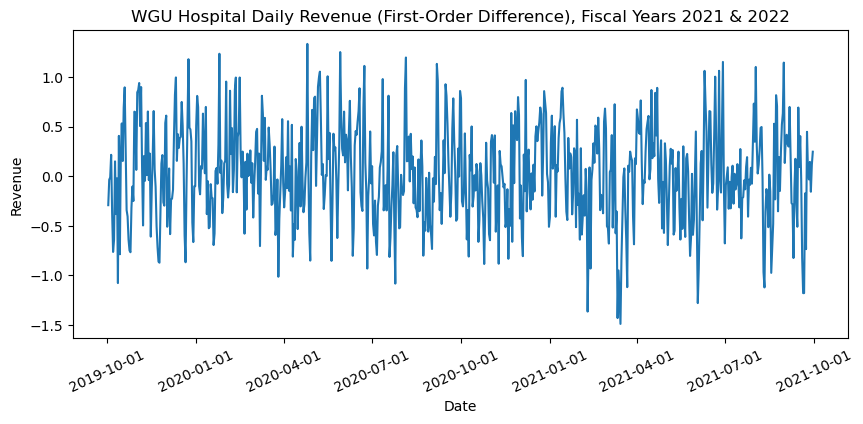

In [9]:
# Create visualization of diffed dataset, to confirm stationarity visually
fig2, ax2 = plt.subplots(figsize=(10, 4))
sns.lineplot(x='Date', y='Revenue', data=diffed_df, ax=ax2)
ax2.tick_params(axis='x', rotation = 25)
ax2.set_title('WGU Hospital Daily Revenue (First-Order Difference), Fiscal Years 2021 & 2022')

# Date format annoys me, so I'll fix it here
ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

plt.show()

## C4. Data Preparation & Splitting
The steps I will be using to prep the data and split it are as follows:

* I will replace the "Day" column with a "Date" column that contains datetime values instead of an incremented integer.
* I will make the new "Date" column the index for the times series data.
* I will make two versions of the dataset.
    * I will difference the original, non-stationary data so that it is stationary and save it as diffed_df.
    * I will save the orginal dataset as df.
* I will split the original data (df) into training and test sets.

I have already performed the first two bullet points in section C1. I explained why I chose to do this in section C2. However, I will briefly reiterate here for clarity. Creating a datetime "Date" column provides context in which to analyze this data. The data dictionary did not state the exact time period in which this data was collected, so I used one that would be commonly used at my work-- two fiscal years (2020 and 2021.) However, the time steps remain the same. The new "Date" column increments the same way the "Day" column did-- each row represents the day's revenue in millions of dollars. In addition to providing context, having a "Date" column that contains datetime values makes it easier to aggregate the data by week, month, year, etc. After the steps in the first two bullets are complete, the data will begin on 10-1-2019 and end on 9-30-2021.

In section C3, the ADF test indicated that the dataset was not stationary. In order to create the visualizations required by section D1, I created a stationary dataset called "diffed_df" which was accomplished by differencing the original dataset once. Please refer to section B for an in-depth explanation of what differencing is, but in short, differencing is when we take the difference between original datapoints in the dataset and use the resulting data for analysis. Differencing once leaves a NaN at the start of the diffed_df dataset, so this NaN wil be dropped. The code for this is in section C3.

For the ARIMA model itself, I will also preserve the original dataset (with the modifications performed in the first two bullet points,) as ARIMA can handle differencing itself-- and it's better to allow it to perform differencing itself. This is the dataset I will split into train and test sets, and it is the dataset I will provide in section C5 as my "cleaned dataset."

I will use train_test_split to split the "df" dataset into train and test sets. I will set the shuffle argument equal to "False" so the data is not rearragned when the split is performed. The test set will contain the last 20% of the data, while the train set will contain the first 80% of the data. This corresponds to a roughly 5 month long test dataset, while the train dataset is roughly a year and a half long (these number are rounded by quite a lot for simplicity's sake.) I chose these percentages for the split because ARIMA is not ideal for long term forecasting, especially not beyond 6 months (Hayes, 2024).

In [11]:
# Split original data. ARIMA should take care of differencing.
train, test = train_test_split(df, test_size = 0.2, shuffle = False, random_state=369)
train

,Revenue
Date,
2019-10-01,0.000000
2019-10-02,-0.292356
2019-10-03,-0.327772
2019-10-04,-0.339987
2019-10-05,-0.124888
...,...
2021-05-02,19.782635
2021-05-03,19.088265
2021-05-04,18.805501


## C5. Cleaned Dataset

Below you will find the code used to export the training set and the testing set.

In [12]:
train.to_csv('213_task1_train_cleaned.csv')
test.to_csv('213_task1_test_cleaned.csv')

## D1. Annotated Findings with Visualizations
The below visuals are generated using the entirety of the differenced dataset, as instructed by Dr. Sewell in his webinars.

### Seasonality

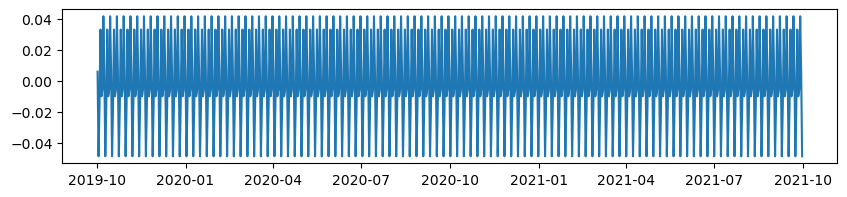

In [17]:
decomposition = seasonal_decompose(diffed_df.Revenue, model='additive')
plt.figure(figsize=(10, 2))
plt.plot(decomposition.seasonal)
plt.show()

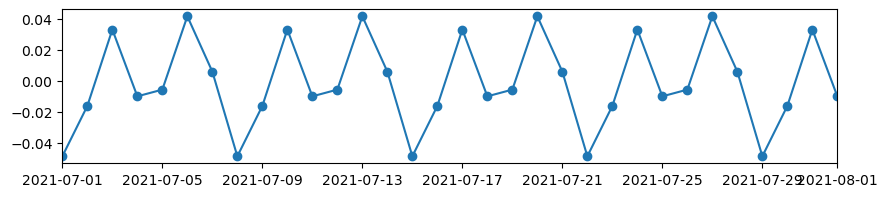

In [18]:
# Zoom in on the plot to get a better idea of what on earth is going on there
# It's so zig-zaggy! Hard to see if there's a pattern.
plt.figure(figsize=(10, 2))
plt.plot(decomposition.seasonal, marker ='o')
plt.xlim(pd.to_datetime('2021-07-01'), pd.to_datetime('2021-08-01'))
plt.show()

# Oh look, a pattern.

The first visual generated to evaluate the seasonal component looks like a fine-toothed comb. It is very difficult to see the minute details of this graph, but it leads me to believe there is a possibility of a seasonal component. Because of that, I "zoomed in" on a section of the first graph so that only a month of data is graphed. In this second graph, a seasonal pattern that repeats every week is readily apparent.

On the zoomed in graphs, it is obvious there is a deep trough every Thursday and a smaller trough every Sunday-- I checked a 2021 calendar for this information. There are two peaks in the time between Thursdays. One occurs on Saturdays, and the other occurs on Tuesdays. Despite the pattern, the magnitude of this seasonal pattern is very, very small-- only ± 0.04 at its greatest. Thus, the impact of this seasonal component will be rather insignificant. Later, in section D2, I will let auto_arima tell me what it thinks the $p$, $d$, and $q$ terms should be. It can also detect seasonality and recommend the terms for a seasonal component. If accounting for this minor seasonality reduces the AIC and thus produces a better model, auto_arima should pick up on it and recommend terms for a SARIMAX model rather than an ARIMA model.

### Trends
The graph below shows no readily apparent trend. Despite the many ups and downs throughout the two years presented here, the graph stays relatively level.

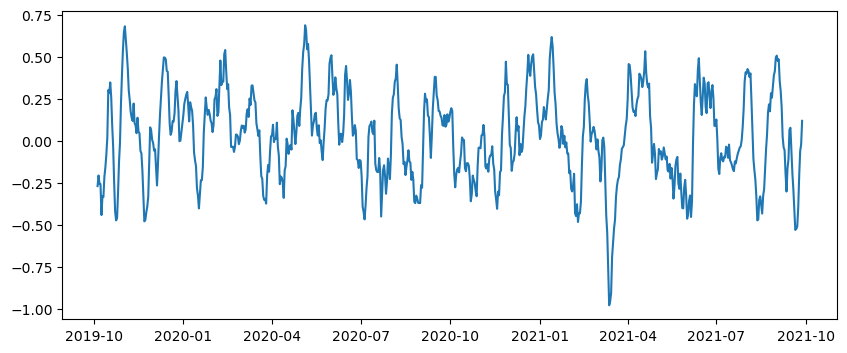

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(decomposition.trend)
plt.show()

### Autocorrelation Functions

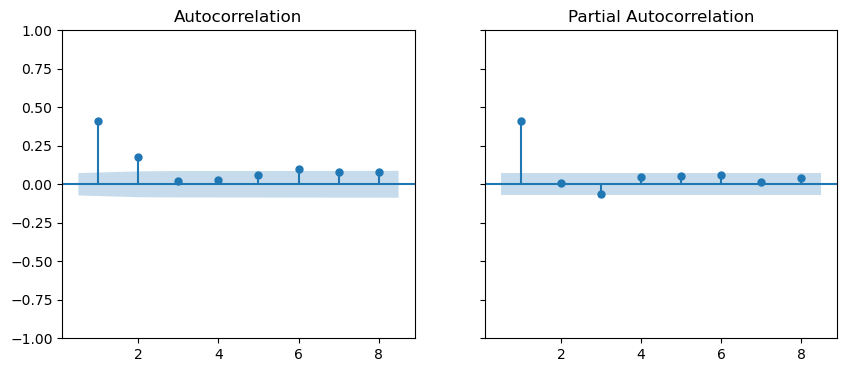

In [20]:
corr_figs, corr_axes = plt.subplots(1, 2, figsize=[10,4], sharey = True)
plot_acf(diffed_df, lags = 8, zero = False, ax = corr_axes[0])
plot_pacf(diffed_df, lags = 8, zero = False, ax = corr_axes[1])
plt.show()

PACF and ACF are used to try and determine $p$ and $q$ respectively. The blue shaded area represents results that are statistically insignificant, so any lines within those areas can be considered as such. While we will later use auto_arima to recommend $p$, $d$, and $q$ for the model, I will also use these graphs to get an idea of what the terms should be. If what I read off these graphs is different from what auto_arima recommends later on, we can check the AIC of both what I read here and what auto_arima recommends and pick the model terms that create the lowest AIC (and thus the better model.)

Since the PACF graph only has one line outside of the blue shaded area, it appears $p$ is 1. Likewise, the ACF graph has two lines outside of the blue shaded area, so I read that $q$ is 2. Since we differenced once, that means one valid model to try for this time series data is a (1,1,2) ARIMA model.

### Spectral Density

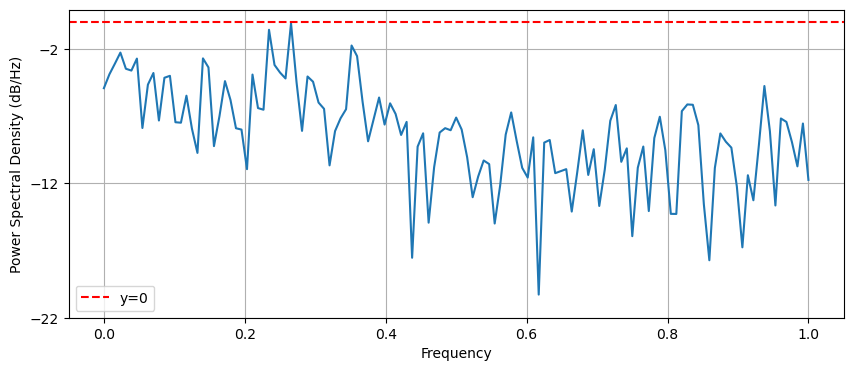

In [25]:
plt.figure(figsize=(10, 4))
plt.psd(x=diffed_df.Revenue)
plt.axhline(y=0, color='red', linestyle='--', label='y=0')
plt.legend()
plt.show()

The spikes in the above Power Spectral Density graph do not follow a specific pattern and appear rather random, implying there is little or no seasonality.

### Decomposition
Even though we've already gone through some of the graphs below one at a time above (trend and seasonal,) here is the full set of graphs that represent the decomposition of the differenced time series. The first graph is simply a graph of the differenced time series itself, but the other three are its decomposed parts.

Figure(640x480)


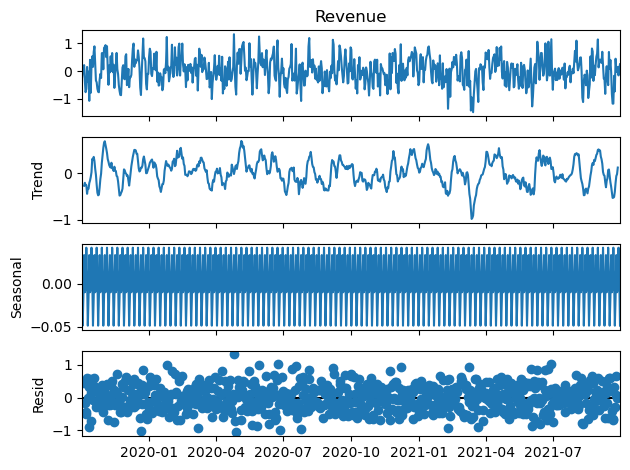

In [35]:
decomp_figs = decomposition.plot()
print(decomp_figs)

### Confirming Lack of Trends in Residuals of Decomposed Time Series
Below is a graph of the differenced dataset's residuals, which do not appear to follow any trend.

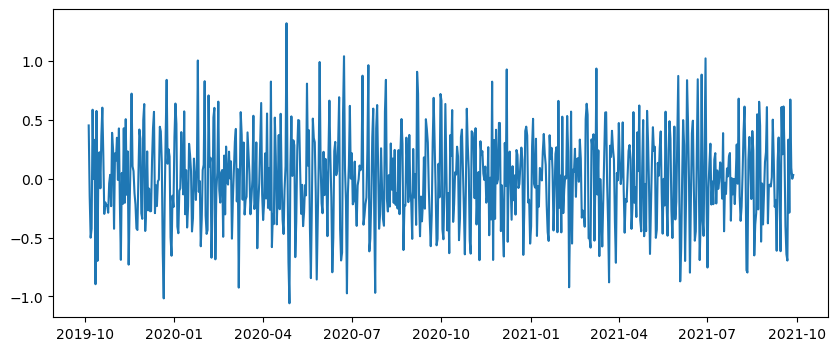

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(decomposition.resid)
plt.show()

## D2. ARIMA Model
I already determined from the PACF graph, ACF graph, and the fact that I had to difference the dataset once to make it stationary that one likely ARIMA model is a (1, 1, 2) model. However, I will also use auto_arima, which runs many models with different terms and recommends the use of whatever model it found had the lowest AIC. It is capable of detecting seasonality, too, which was a concern above because the dataset appeared to have seasonality, however insignificant it was.

Below is the code that runs auto_arima and also the code that runs the model I thought would be best-- the (1, 1, 2) model. The output states auto_arima's recommended model's AIC next to the (1, 1, 2) model's AIC.

In [39]:
# The above steps seem to indicate an order of (1, 1, 2) for the model,
# but let's try out auto_arima and see what it thinks.

stepwise_fit = auto_arima(df['Revenue'], trace=True, suppress_warnings=True)
best_model_aic = stepwise_fit.aic()
print(f"Best Model AIC: {best_model_aic}")

# Let's also see what the AIC is for the model I think was indicated
# by the pacf and acf graphs (1,1,2)

indicated_model = ARIMA(df['Revenue'], order=(1,1,2), freq='D')
indic_results = indicated_model.fit()
indic_aic = indic_results.aic
print(f"Indicated Model AIC: {indic_aic}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.35 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.522 seconds
Best Model AIC: 879.9818304707662

In [40]:
# Instead of differencing the data myself (which I did anyway earlier)
# I'm going to let ARIMA do it by specifying the order auto_arima found,
# Which includes a differencing term, d = 1 (which is the same as earlier)

model = ARIMA(train['Revenue'], order=(1,1,0), freq='D')
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -350.812
Date:                Sun, 22 Sep 2024   AIC                            705.625
Time:                        17:54:07   BIC                            714.361
Sample:                    10-01-2019   HQIC                           709.030
                         - 05-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.837      0.000       0.336       0.485
sigma2         0.1950      0.012     15.888      0.000       0.171       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.70   Prob(JB):                         0.39
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Since auto_arima's (1, 1, 0) model with no seasonality was *ever* so slightly better than my (1, 1, 2) model, I will use auto_arima's suggestion. Auto_arima's model's AIC was, however, only 0.008 better than the (1, 1, 2) model, which seems to indicate the use of either model would be fine.

Above, you'll find the code that I used to fit the (1, 1, 0) model to the train dataset. On the train dataset, the model achieved an AIC of 705.625.

## D3. Forecasting
Below you'll find the code I used to create the forecast. The first graph plots only the predictions, while the second graph plots the predictions along with the train and test data for comparison.

In [42]:
# Get train and test length
print("Length of Train Set: " + str(len(train)))
print("Length of Test Set: " + str(len(test)))

Length of Train Set: 584
Length of Test Set: 147


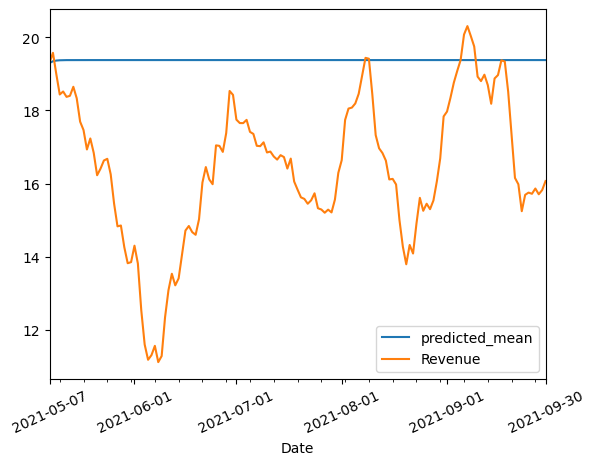

In [43]:
# Create forecast

start = len(train)
end = len(train) + len(test)-1
preds = model_results.predict(start=start, end=end, dynamic=True)

# Plot predicted_mean vs the actual test data.

preds.plot(legend=True)
test['Revenue'].plot(legend=True)

# Date format annoys me, so I'll fix it here
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=25)
plt.show()

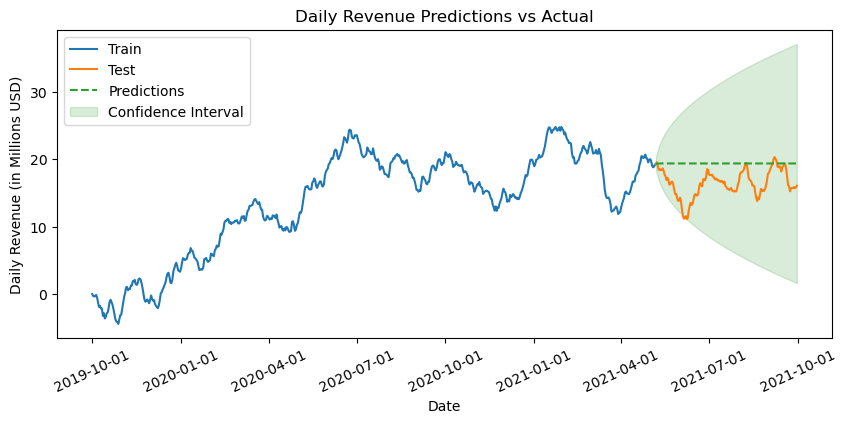

In [44]:
# Get data for confidence intervals [In-Text Citation: (Bhatt, 2023).]
forecast = model_results.get_forecast(steps=len(test))
forecast_series = pd.Series(forecast.predicted_mean, index=test.index)


# Plot train, test, and preds together.
plt.plot(train['Revenue'], label='Train')
plt.plot(test['Revenue'], label = 'Test')
plt.plot(forecast_series, label = 'Predictions', linestyle='dashed')
plt.fill_between(test.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], 
                 color='g', alpha=.15, label='Confidence Interval')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Daily Revenue (in Millions USD)')
plt.title('Daily Revenue Predictions vs Actual')
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=25)
plt.show()

The graph above shows WGU Hospital's daily revenue. The blue line represents the train data (80% of the time series data,) while the orange line represents the test data (20% of the time series data.) The green line represents the model's predictions, and the green cone is the confidenced intervale, which is quite wide.

## D4. Output & Calculations
All output and calculations have been provided above, besides the RMSE calculation. The calculation for my selected metric, RMSE, can be found in section E1, where the subject is relevant.

## D5. ARIMA Model Code
The code used to implement the model has been provided in section D2, but just to be safe, it is also below.

In [45]:
model = ARIMA(train['Revenue'], order=(1,1,0), freq='D')
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -350.812
Date:                Sun, 22 Sep 2024   AIC                            705.625
Time:                        18:12:29   BIC                            714.361
Sample:                    10-01-2019   HQIC                           709.030
                         - 05-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.837      0.000       0.336       0.485
sigma2         0.1950      0.012     15.888      0.000       0.171       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.70   Prob(JB):                         0.39
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## E1. Analysis Results

<Figure size 2000x2000 with 0 Axes>

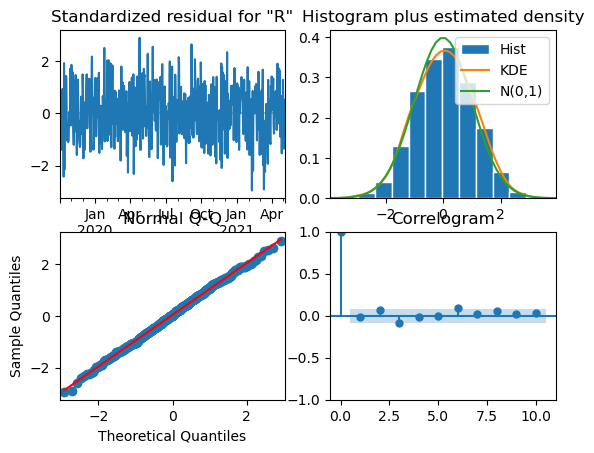

In [46]:
plt.figure(figsize=[20,20])
model_results.plot_diagnostics()
plt.show()

In [47]:
# Root Mean Squared Error Calculation

rmse = np.sqrt(mean_squared_error(test['Revenue'], preds))
print(f"RMSE = {rmse}")

RMSE = 3.5608158808515395


As I have already stated, my model selection was based on the following process. I differenced the data once to make it stationary, which immediately told me $d = 1$. Then, using the differenced data, I plotted ACF and PACF. Since the PACF graph only had one line outside of the blue shaded area, it appeared $p = 1$ Likewise, since the ACF graph had two lines outside of the blue shaded area, I interpreted that as $q = 2$. This meant one valid model to try for this time series data was a (1, 1, 2) ARIMA model. However, there also exists functionality in the pmdarima library that can be used to recommend an ARIMA model. From this library, we get auto_arima, which runs many models with many different $p$, $d$, and $q$ terms. Auto_arima then recommends the model it found to have the lowest AIC. It can even detect seasonality and provide the terms for the seasonal component as well. After running auto_arima on this time series, it suggested a (1, 1, 0) model with no seasonality component that had achieved an AIC of 879.981. I then ran my (1, 1, 2) model, which achieved an AIC of 879.989-- just a hair higher than auto_arima's suggested model. Because we want to minimize AIC, I selected auto_arima's (1, 1, 0) model as my final model.

The prediction interval of the forecast is 147 steps after the training data ends. This corresponds to a time period of 4.9 months. Predictions were made based on 584 days of data (about 1.62 years of data.) It is worthwhile to note that there is a definite upward trend in the original time series dataset that lasts from 10-1-2019 through 7-1-2020, corresponding to the first 9 months of data. It levels off thereafter. While we lack context for this data, this initial upward trend from near 0 to roughly 25 million dollars in revenue per day could be indicative of a business that has recently started operation. As such, revenue grew from nothing to the place it would plateau for the remainder of the dataset. If this is the case, the first 9 months of the dataset may not be as informative and predictive as we would like, since a business starting up is a one-time event never to happen again. Since there are 274 days of this upward trend and our train dataset is only 584 days long, this means that roughly 47% of the train dataset may be less useful than we thought, hindering the model's predictive value.

In regards to the forecast length, a nearly 5 month forecast is a bit ambitious for an ARIMA model, as it is not designed for long-term forecasting. However, sources indicate that so long as the forecast does not go beyond 6 months, it is trustworthy (Hayes, 2024). Many businesses in the real world prefer to forecast as far out as they can do so reliably, and I believe the selection of an almost 5 month forecast is both safely within the limits of the ARIMA model and correct based on most businesses' needs and desires.

Finally, we can evaluate the model's performance using a metric. In this case, I will use RMSE or root mean squared error. You can find the code that calculates the model's RMSE on the test dataset above. This metric tells us the average distance between the model's predictions and the actual test dataset values. A lower RMSE is a better RMSE. With an RMSE of 3.56, this model is usually about 3.56 million dollars off from the actual test dataset values. Given the range of the dataset, I would say that this is not bad.

I have also provided diagnostic plots for the model above, which illustrate the model's performance. The plot in the top left is a standardized residual plot. Ideally, this should show no patterns-- and our model's plot does not, which is good. The plot in the top right is a histogram with a KDE estimate. Ideally, the KDE line should closely follow the normal distribution, which ours does. This is also good. The bottom left plot contains a Normal Q-Q plot. In this plot, it is ideal if the points are on or very near the red line, which is the case with ours. Once again, this is good. Finally, the bottom right plot contains a correlogram, which ideally should show correlations for all lags greater than zero to be insignificant. Our correlogram shows just that, though this is a bit subjective regarding lags 3 and 6.

## E2. Forecast Visualization
Though I have provided it above, just to be safe, I have provided the visualization for the forecast again below.

The forecast is nearly flat and basically follows $y = 19$, which seems to follow the trend of the test data and the data in the training set before it. It is not very detailed, however. It lacks the natural dips and peaks of the real test data, which makes me suspicious of its quality. Because it is flat, I am also concerned it is not very practical. The forecast fails to predict fairly significant dips in the test data, such as the one that bottoms out at roughly 6-1-2021. This dip represents a drop in revenue from roughly 20 million that day to roughly 12 million, which is quite a lot. Since it occurs immediately after the train dataset ends, one would hope the model would catch the beginning of that trend and predict it, especially because the dip begins to occur at the very end of the training dataset. Unfortunately, since the model's predictions seem mediocre at best-- almost as if I had simply drawn a trend line on the graph-- this model does lack practical significance despite its decent RMSE value.

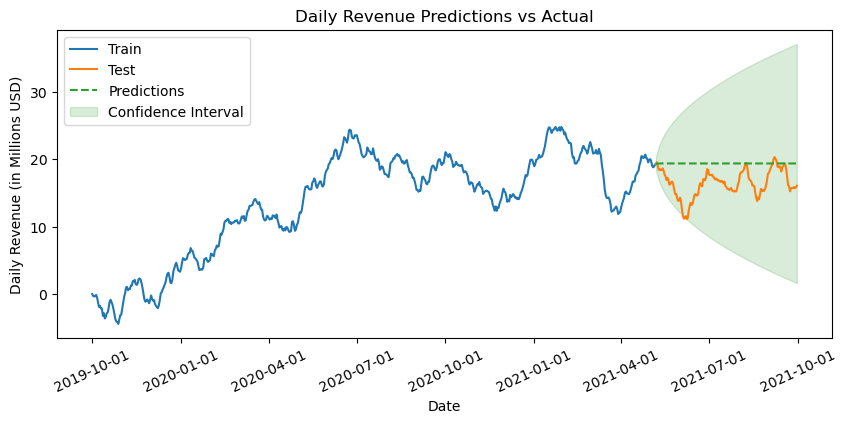

In [48]:
# Plot train, test, and preds together.
plt.plot(train['Revenue'], label='Train')
plt.plot(test['Revenue'], label = 'Test')
plt.plot(forecast_series, label = 'Predictions', linestyle='dashed')
plt.fill_between(test.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], 
                 color='g', alpha=.15, label='Confidence Interval')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Daily Revenue (in Millions USD)')
plt.title('Daily Revenue Predictions vs Actual')
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=25)
plt.show()

## E3. Recommended Action
This model lacks practical significance. This could be due to a number of things, such as the lack of a sufficiently long period of historical data upon which to make predictions or the possibility that the historical data began being collected at the start-up of WGU Hospital, leading to the first 9 months of data lacking predictive strength. Both of these issues were discussed at length in the above commentary. 

Since these are concerns, I would suggest the following: The analyst could wait another couple of years before attempting to forecast using ARIMA, especially if the data used in this analysis began being collected when WGU Hospital first began operating. I would advise, in the case that the first 9 months of data *does* reflect the business starting up, that the first 9 months of data be omitted from future ARIMA models, as WGU Hospital starting up as a business is a one-time event and lacks predictive power. More data, of course, is always better, so waiting a couple of years to gather a larger dataset that reflects normal operations will be beneficial whatever the case may be.

If the analyst would rather improve *this* model, I would suggest running auto_arima with the argument "stepwise" set to False while also specifying start and end p, d, q, P, D, and Q values. This would cause auto_arima to perform a more time-consuming and computationally costly grid search that evaluates all possible models within the p, d, q, P, D, and Q constraints rather than evaluating only a small subset of models. It is possible doing this may turn up a model with a lower AIC, which might be a better model.

## F. Reporting
The content above is my report and will be included as both an IPYNB file as well as a PDF.

## G. Code Sources
Bhatt, D. (2023, November 7). Time Series Analysis and Forecasting with ARIMA in Python. *Medium.* https://medium.com/datainc/time-series-analysis-and-forecasting-with-arima-in-python-aa22694b3aaa

## H. Content Sources
Hayes, A. (2024, July 31). *Autoregressive Integrated Moving Average (ARIMA) Prediction Model.* Investopedia. https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp#:~:text=ARIMA%20modeling%20is%20generally%20inadequate,picture%20of%20an%20asset's%20performance. 

Singh, A. (2023, May 23). *Build High Performance Time Series Models using Auto ARIMA in Python and R.* Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/ 

*What are Autoregressive Models? - AR Models Explained - AWS.* (n.d.). Amazon Web Services, Inc. https://aws.amazon.com/what-is/autoregressive-models/#:~:text=Autocorrelation%20is%20a%20statistical%20method,lagged%20inputs%20of%20a%20model.